# Modeling and Insights

In [1]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyhere import here
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load data

In [2]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
# for plotting, transform to geographical crs 
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        gdf = gdf.to_crs(epsg=4326)
        #save to dict
        gdfs[filename] = gdf

In [3]:
# load datasets for modeling

# mining data
mining_gdf = gdfs['bergbaugebiete__v1_poly']

# groundwater data 
water_gdf = gdfs['gwerg__v11_poly'] 


# Preprocess and feature engineering

<Axes: >

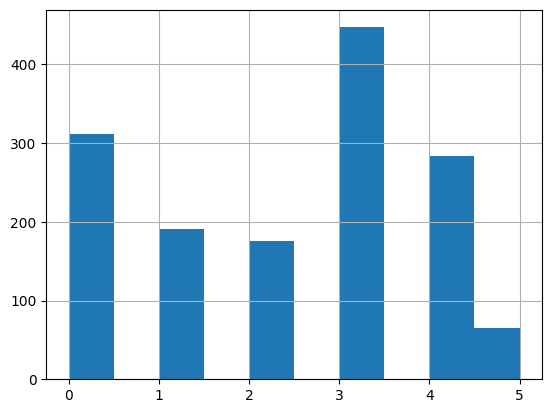

In [4]:
# Target variable: numerical oridinal encoding
water_gdf['entn_bru'] = water_gdf['entn_bru'].fillna('None') # none for no extraction at all
entn_dict = {'None': 0, 'meist < 2 (l/s)': 1, 'meist < 5 (l/s)': 2, 'meist 5 - 15 (l/s)': 3, 'meist 15 - 40 (l/s)': 4, 'meist > 40 (l/s)': 5}
y = water_gdf['entn_bru'].map(entn_dict)
y.hist()

In [5]:
# Feature 1: 'gestein' dummy encoded
# replace missing "gestein" with string
water_gdf['gestein'] = water_gdf['gestein'].astype('str')
# one hot encoding of gestein
gestein_encoded = pd.get_dummies(water_gdf["gestein"], prefix="gestein")
water_gdf = pd.concat([water_gdf, gestein_encoded], axis=1)

In [6]:
# Feature 2: 'Bedeutung' label encoded (ordinal)
# replace missing with string
water_gdf['bedeutung'] = water_gdf['bedeutung'].astype('str')
bedeut_dict = {'None': 0, 'Keine bedeutenden Grundwasservorkommen': 1, 'Weniger bedeutende Grundwasservorkommen': 2, 'Bedeutende Grundwasservorkommen': 3}
water_gdf['bedeutung_cat'] = water_gdf['bedeutung'].map(bedeut_dict)


<Axes: >

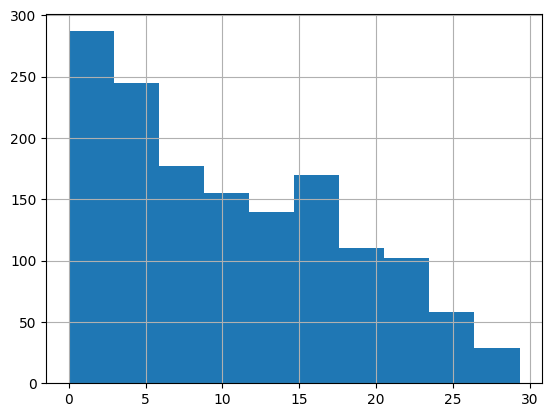

In [7]:
# Feature 3: Distance of each groundwater geometry centroid to nearest mining polyline

# Reproject both datasets
projected_crs = "EPSG:32632"
water_gdf = water_gdf.to_crs(projected_crs)
mining_gdf = mining_gdf.to_crs(projected_crs)

# Get centroids of water source areas
water_centroid = water_gdf.geometry.centroid

# Compute distance from each centroid to the nearest mining polyline
water_gdf["distance_to_mining"] = water_centroid.apply(
    lambda point: mining_gdf.geometry.distance(point).min() / 1_0000 # to km
)
water_gdf["distance_to_mining"].hist()

<Axes: >

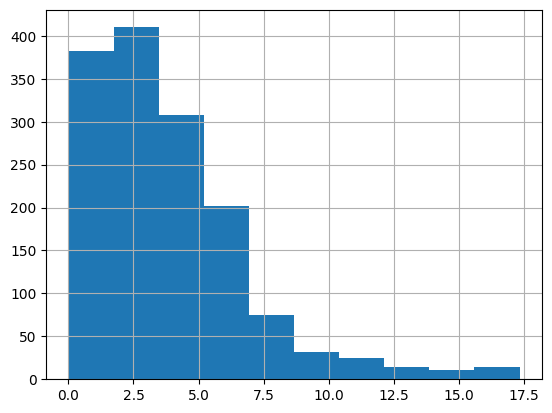

In [8]:
# Feature 4: Proximity to rivers or lakes

bank_gdf = gdfs['uferfiltrat__v1_line']
# tconvert o projected crs
bank_gdf = bank_gdf.to_crs(projected_crs)

# Compute distance from each water area centroid to the nearest waterbank
water_gdf["distance_to_waterbanks"] = water_centroid.apply(
    lambda point: bank_gdf.geometry.distance(point).min() / 1_0000) # to km

# check distribution of distance
water_gdf.distance_to_waterbanks.hist()

<Axes: >

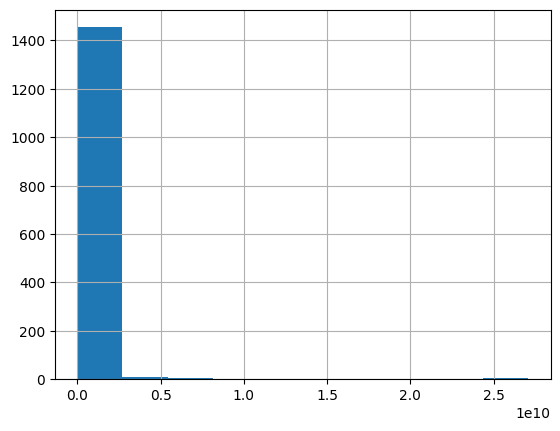

In [9]:
# Feature 5: area log transformed (because it is shighly skewed)
water_gdf['Shape_STAr'].hist()

<Axes: >

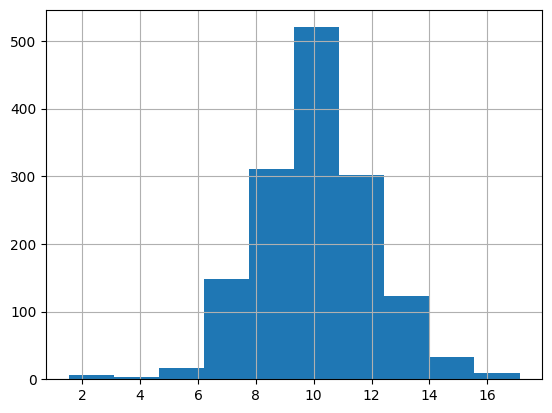

In [10]:
water_gdf['log_area'] = np.log(water_gdf['Shape_STAr'] / 1_000 )
water_gdf['log_area'].hist()


In [11]:
# Define feature array (X)
X = water_gdf.drop(columns = ['erg_id','entn_werk', 'gestein_id', 'ergiebigke', 'bedeutung', 'entn_bru', 'gestein', 'Shape_STAr', 'Shape_STLe', 'geometry', ])

In [12]:
X

,"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",gestein_None,"gestein_Sand, Kies, Tuff (Porenwasserleiter)","gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",bedeutung_cat,distance_to_mining,distance_to_waterbanks,log_area
0,False,False,True,False,3,27.599427,12.776758,14.309971
1,False,True,False,False,1,28.379206,16.350886,9.315953
2,False,False,True,False,3,27.430476,15.618993,9.202513
3,False,False,True,False,3,28.869077,12.454141,12.194188
4,False,False,True,False,3,28.714522,14.033133,9.734217
...,...,...,...,...,...,...,...,...
1468,True,False,False,False,3,2.843375,2.883728,10.331405
1469,False,False,True,False,3,0.046231,0.200276,14.896652
1470,False,False,True,False,3,2.314534,3.224579,9.603864
1471,False,False,True,False,3,0.675877,3.686623,13.100758


### Modeling

In [13]:
# check correlation matrix
corr_matrix = pd.concat([y, X], axis=1).corr()
corr_matrix 

,entn_bru,"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",gestein_None,"gestein_Sand, Kies, Tuff (Porenwasserleiter)","gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",bedeutung_cat,distance_to_mining,distance_to_waterbanks,log_area
entn_bru,1.000000,0.166800,-0.873283,0.616486,0.180619,0.948756,-0.034624,-0.129857,0.390414
"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",0.166800,1.000000,-0.230710,-0.278786,-0.123845,0.189961,-0.102631,-0.021229,0.148152
gestein_None,-0.873283,-0.230710,1.000000,-0.632309,-0.280890,-0.931659,0.087507,0.055715,-0.373279
"gestein_Sand, Kies, Tuff (Porenwasserleiter)",0.616486,-0.278786,-0.632309,1.000000,-0.339423,0.621144,0.100051,-0.068665,0.138401
"gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",0.180619,-0.123845,-0.280890,-0.339423,1.000000,0.236064,-0.182028,0.040636,0.194994
bedeutung_cat,0.948756,0.189961,-0.931659,0.621144,0.236064,1.000000,-0.080912,-0.094108,0.420825
distance_to_mining,-0.034624,-0.102631,0.087507,0.100051,-0.182028,-0.080912,1.000000,0.348098,-0.159142
distance_to_waterbanks,-0.129857,-0.021229,0.055715,-0.068665,0.040636,-0.094108,0.348098,1.000000,-0.176913
log_area,0.390414,0.148152,-0.373279,0.138401,0.194994,0.420825,-0.159142,-0.176913,1.000000


In [14]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [16]:
# Compute error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.2766101694915254
Mean Squared Error (MSE): 0.19239050847457626
R² Score: 0.909108367805609


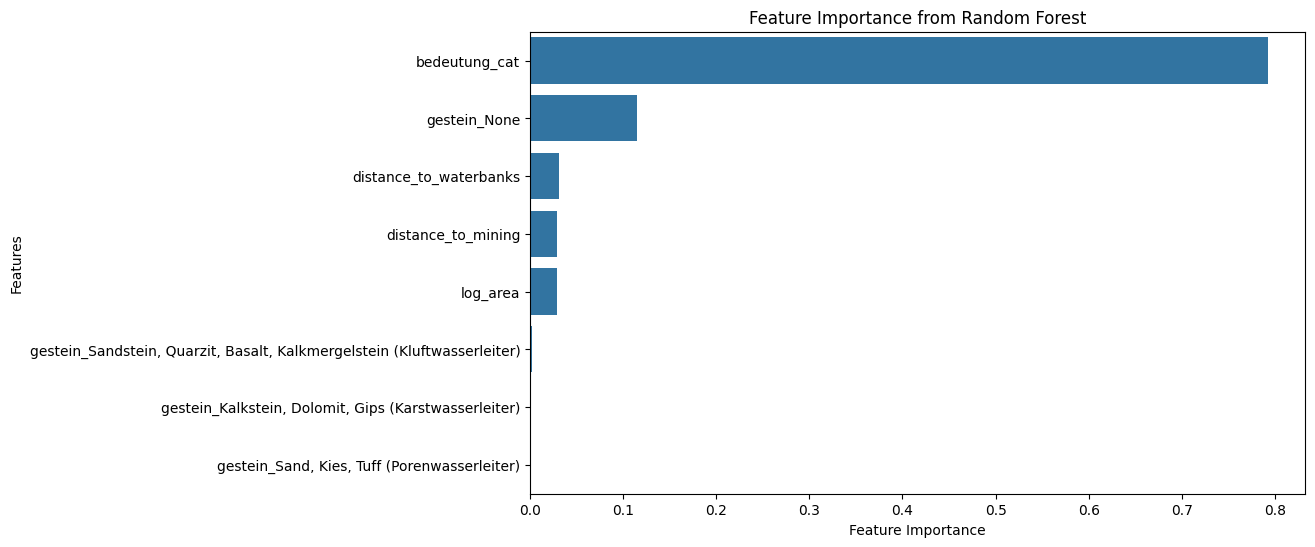

In [17]:
#Get feature importance
feature_importance = model.feature_importances_
features = X.columns


# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
sorted_features = np.array(features)[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()

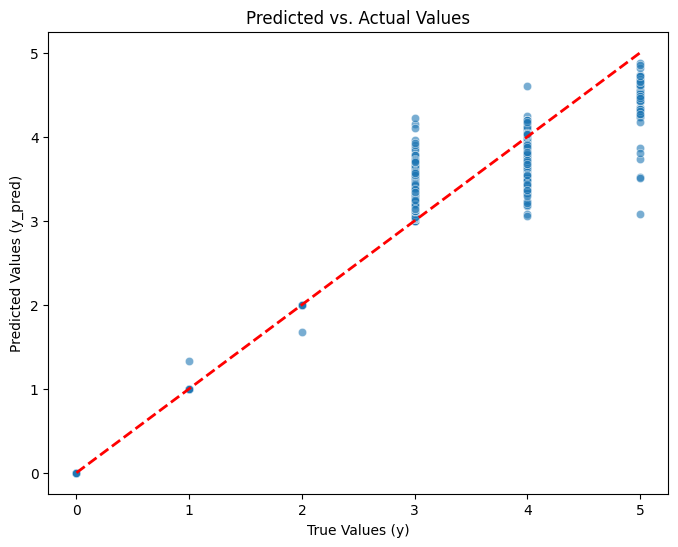

In [18]:
# make overfitting predictions for all data and plot y_true againd y_pred
y_pred_all = model.predict(X)

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred_all, alpha=0.6)

# Add a diagonal reference line (perfect predictions)
min_val = min(min(y), min(y_pred_all))
max_val = max(max(y), max(y_pred_all))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Labels and title
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs. Actual Values")

plt.show()


### Interpretation

The objective was to fit a simple prediction model for the potential water extraction yield at a well ('ent_bru'). 
The target variable is ordinally scaled from 0 (no extraction potential) to 5 (highest extraction potential).
Ideally, an ordinal regression model (such as ordinal ridge) should be fitted. For simplicity, I treat it as continuous.  
For simplicity, a random forest regression model is fitted with 20 - 80 test-train split.
No cross validation or hyperparameter tuning was performed.
The following features were generated/included:
-   geological formations one-hot-encoded 
-   log(area) of the water bearing geographies (log_area)
-   distance of the centroid of the water bearing geography's centroid to nearest waterbank, in km (distance_to_waterbank)
-   distance of the centroid of the water bearing geography's centroid to nearest mining area, in km (distance_to_mining)
-   importance of the groundwater bearing area (bedeutung_cat) label encoded (ordinal feature 0-5)

The feature bedeutung_cat has the highest importance  for predicting water extraction potential. However, this might be due to the fact that it is determined by some sort of secondary assessment jointly with entn_bru (hence it is not truely independent). The same is likely to for the features ergiebigke and entn_werk. This would have to be investigated in a more in depth study.

The second most predicting feature for ent_bru is gestein_None (no relevant geological formation in the area).

Distance to neares mining area, distance to nearest water bank, as well as the size of the water bearing area (log_area) are also predictive of extraction potential. 

The model metrics indicate a good fit, potentially some overfitting that would need to be addressed, e.g. by reducing the potentially non independent features and applyling cross-validations.

- Mean Absolute Error (MAE): ~0.277 → On average, predictions are off by ~0.28 units.

- Mean Squared Error (MSE): ~0.192 → Larger errors are penalized more, it would require further investigation why it is smaller than the MAE.

- R² Score: ~0.909 → The model explains ~90.9% of the variance in the data (strong fit).

